# Explanation through rollouts
This notebook explains a move as a part of tactic by cutting rollout, using entropy changes as the game proceeds. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import time

# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense

# Chess Libraries
import chess #version: 0.27.3
import chess.uci
import chess.pgn
import chess.svg

# Scipy 
from scipy.stats import entropy
from scipy.special import softmax

# Handling svg's
import cairosvg
import time

# Path to stockfish chess engine
handler = chess.uci.InfoHandler()
engine = chess.uci.popen_engine('/home/shripad/Desktop/Shripad/Downloaded_Codes/stockfish-saliency/stockfish-10-linux/Linux/stockfish_10_x64') #give correct address of your engine here
engine.info_handlers.append(handler)

Using TensorFlow backend.
/home/shripad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The chess.uci module is deprecated in favor of
chess.engine <https://python-chess.readthedocs.io/en/latest/engine.html>.

Please consider updating and open an issue
<https://github.com/niklasf/python-chess/issues/new> if your use case
is not covered by the new API.
  del sys.path[0]


In [2]:
# Data Generation Cell 


def return_q_vals(board, evaltime = 100):
    '''Function takes chess.Board as the argument and returns 10 sorted Q-values in descending order'''
    q_vals = []
    
    for el in board.legal_moves:
        
        engine.position(board)
        engine.go(searchmoves=[el],movetime=evaltime)
        
        if handler.info["score"][1].cp is None:
            score = handler.info["score"][1].mate
        else:
            score = round(handler.info["score"][1].cp/100.0,2)
            
        q_vals.append(score)
    
    return np.asarray(sorted(q_vals, reverse=True)[:min(len(q_vals), 10)] )


def calc_entropy(board):
    '''Function to calculate the entropy based on the Q-values'''
    
    if board.is_game_over():
        return 0
    
    q_vals = return_q_vals(board, evaltime = 100)
    
    if not board.turn:
        q_vals = [-x for x in q_vals]
        
    policy = softmax(q_vals)
    entropy_board = entropy(policy)
    
    return entropy_board

def save2pkl(l, filename):
    '''Function to store the lists of tactics in text file '''
    with open('dataset/' + filename + '.txt', "wb") as fp:   #Pickling
        pickle.dump(l, fp)
        
        

def generate_list(game):
    '''Function takes a game read from a pgn using method chess.pgn.read_game() and returns a list of moves and their corresponding entropies'''
    board = game.board()
    original_fen = board.fen()
    
#     Model is trained only when it is white's turn 
    if not board.turn:
        return None
    
    l = []
    
    num_moves_played = 0
    last_move_played = None
    
    entropy_diff = None
    last_entropy = None
    
    
    # First let  the pgn moves get over
    for move in game.mainline_moves():
        if(num_moves_played % 2 == 0):
            entropy1 = calc_entropy(board)
            l.append([move.uci(),entropy1, 0])
        
        board.push(move)
        
        last_move_played = move.uci()
        num_moves_played += 1
    
#     Even the checkmates are removed from the dataset
    if board.is_game_over():
        return None
    
    # Check if the game was over after the tactic, otherwise...
    # Once play with opponent and then play post tactic move and store it to be 'Tactic finished : true'

    if num_moves_played %  2 == 1:
        if not board.is_game_over():
            # Opponent Plays
            engine.position(board)
            evaluation = engine.go(movetime=100)
            bestmove = evaluation.bestmove

            board.push(bestmove)

        
    entropy1 = calc_entropy(board)

    l.append(['end',entropy1, 1])
    
    return l

In [3]:
# Cell to process the data 
def make_windows(x_list, size = 3):
    '''Function takes a sequence of entropies as a list and  generates a list of windows of a given size'''
    xx_list = []
    for i in range(len(x_list) - size + 1):
        xx_list.append(x_list[i:i+size])
        
    return xx_list

def measure_acc(y_test, y_test_pred):
    '''Function to measure accuracy of the prediction while classifying'''
    count = 0.
    for i in range(len(y_test)):
        if y_test[i] == y_test_pred[i]:
            count += 1.
    return count*1.0/len(y_test)

def sig_to_binary(x):
    '''Function to round the probabilities to 0/1'''
    x[x>=0.5] = 1
    x[x<0.5] = 0
    
    return x

In [4]:
# Cell for cutting a rollout

def play_next_move(board):
    '''Function to make the next move using the agent, returns board and the best move'''
    engine.position(board)
    evaluation = engine.go(movetime=100)
    bestmove = evaluation.bestmove
    
    board.push(bestmove)
    return board, bestmove.uci()

def rollout_explanation(board):
    '''Given the board position, gives the explanation as a rollout of moves'''
    rollout = []
    entropies = []
    num_moves = 0
    
    while ((not board.is_game_over()) and len(entropies) < 3) :
        if(num_moves%2 == 0):
            entropy1 = calc_entropy(board)
            entropies.append(entropy1)
        board, move_played = play_next_move(board)
        
        rollout.append(move_played)
        
        num_moves += 1
    
    
    window = np.asarray(entropies)
    window = np.expand_dims(window, axis = 0)
    
    while not board.is_game_over():
#         print(window, window.shape)
        y = sig_to_binary(model.predict(window)[:, -1])
#         print('y = ', y)
        if y[0] == 1.:
            break
        
        board, move = play_next_move(board)
        rollout.append(move)
        
        board, move = play_next_move(board)
        rollout.append(move)
        
        entropy1 = calc_entropy(board)
        
        window[0 : ] = np.array([window[0][1], window[0][2], entropy1])
    return rollout


def fen_to_png(fen, rollout, pgn_filename = 'tactic'):
    '''
    Function takes initial FEN and the rollout, saves images of the moves in png as well as svg format.
    Also saves pgn of the rollout.
    '''
    game = chess.pgn.Game()
    game.setup(chess.Board(fen = fen))
    game.headers["Event"] = ""
    
    svg_filepath = 'results/'  + '/svg/' 
    png_filepath = 'results/'  + '/png/' 
    pgn_filepath = 'results/'  + '/pgn/'
    
#   Erase the folders first
    !rm -f results/svg/*
    !rm -f results/png/*
    
#   Adding the image of the board
    board = chess.Board(fen)
    svg = chess.svg.board(board)
    with open(svg_filepath + 'board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url=svg_filepath + 'board.svg', write_to=png_filepath +  'board.png')
    
    
#   Adding the images of the rollout
    node = None
    
    board = game.board()
    count = 0
    for move in rollout:
        if node is None:
            node = game.add_variation(chess.Move.from_uci(move))
        else:
            node = node.add_variation(chess.Move.from_uci(move))
        
        move1 = chess.Move.from_uci(move)
        board.push(move1)
        
        board_name = 'board_' + str(count)
        svg = chess.svg.board(board,  arrows = [chess.svg.Arrow(move1.from_square, move1.to_square, color = '#FF0000')])
        count += 1

        with open(svg_filepath + board_name + '.svg', 'w+') as f:
            f.write(svg)
        
        cairosvg.svg2png(url=svg_filepath + board_name + '.svg', write_to=png_filepath + board_name + '.png')

#   Saving the pgn of the rollout 
    print(game, file=open(pgn_filepath + pgn_filename + '.pgn', "w"), end="\n\n")
    


In [5]:
# # Uncomment this cell to generate the data instead of using the given data file, it takes around 15 hrs

# # Open pgn files for games
# pgn = open("training_pgns/auerswald.pgn")

# # Dictionary of all the tactics
# tactics = {}
# save_after = 100

# # Initialize 
# game = chess.pgn.read_game(pgn)
# i = 0

# while game is not None:
#     board = game.board()
#     l = generate_list(game)
#     if l is not None:
#         tactics[board.fen()] = l
#         i += 1
#         print(i, '\r', end='')
        
#         if(i%save_after == 0):
#             print('Saving first', i)
#             save2pkl(tactics, filename = "list_" + str(i))
#             print('----------------------------')    
# #         Note that new entries generated are appended to previous one to give a larger list and is saved in a new file  
    
    
#     game = chess.pgn.read_game(pgn)

## Format in which data is stored
tactics = Dictionary { Key =  FEN : Value = List ( \[ Move, Entropy \] ) }



In [6]:
# # Uncomment this cell to load data
# # This cell loads the dataset and makes the windows with corresponding labels
# tactics = {}

# with open("dataset/list_1700.txt","rb") as pkl_file:
#     tactics = pickle.load(pkl_file)
    
    
# x = []
# y = []
# for fen in tactics:
#     x_data = []
#     y_data = []
    
#     board = chess.Board(fen = fen)

#     for m_e_b in tactics[fen]:
        
#         move = m_e_b[0]
#         entropy1 = m_e_b[1]
#         b =  m_e_b[2]
        
        
#         x_data.append(entropy1)
#         y_data.append(b)
        
    
#     x += make_windows(x_data)
#     y += make_windows(y_data)

# x = np.asarray(x)

# y = np.asarray(y)
# y = y[:,-1]


# # Train and test split 
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# # print(x_train.shape, y_train.shape)

In [7]:
# Neural Network to learn where to cut the rollout
def create_baseline():
    # create model
    model = Sequential()
    
    layer0 = 3 # Input layer
    layer1 = 6 # First Hidden Layer
    layer2 = 7 # Second Hidden Layer
#     layer3 = 6 # Third Hidden Layer
    
    model.add(Dense(layer1, input_dim=layer0, use_bias=True, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(layer2, input_dim=layer1, use_bias=True, kernel_initializer='normal', activation='tanh'))
#     model.add(Dense(layer3, input_dim=layer2, use_bias=True, kernel_initializer='normal', activation='tanh'))

    model.add(Dense(1, input_dim = layer2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_baseline()
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 49        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [8]:
# # Uncomment this cell if you want to train yourself
# model.fit(x_train, y_train, epochs=100)


In [9]:
# Comment to this cell in case you don't want to use trained model. 
model.load_weights('weights/nn_rollout_cutting.h5')

In [10]:
# y_test_pred = model.predict(x_test)
# y_test_pred = sig_to_binary(y_test_pred)
# print(measure_acc(y_test, y_test_pred))

In [11]:
def rollout_explanation(board):
    '''
    This function takes board FEN as input and outputs rollout and entropies.
    '''
    rollout = []
    entropies = []
    num_moves = 0
    
    while ((not board.is_game_over()) and len(entropies) < 3) :
        if(num_moves%2 == 0):
            entropy1 = calc_entropy(board)
            entropies.append(entropy1)
        board, move_played = play_next_move(board)
        
        rollout.append(move_played)
        
        num_moves += 1
    
    
    window = np.asarray(entropies)
    window = np.expand_dims(window, axis = 0)
    
    while not board.is_game_over():
        y = sig_to_binary(model.predict(window)[:, -1])
        if y[0] == 1.:
            break
        
        board, move = play_next_move(board)
        rollout.append(move)
        
        board, move = play_next_move(board)
        rollout.append(move)
        
        entropy1 = calc_entropy(board)
        entropies.append(entropy1)
        
        window[0 : ] = np.array([window[0][1], window[0][2], entropy1])
    
    return rollout, entropies

In [12]:
# Change the fen to get the rollout for certain tactic
fen = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board = chess.Board(fen)
rollout, entropies = rollout_explanation(board)
fen_to_png(fen, rollout)
print(rollout)
print(entropies)

['g2g4', 'f5f6', 'f4g5', 'f6e5', 'e1e5', 'a7b8', 'e5c5']
[0.045392636336011746, 0.021153961376794966, 8.029624757140351e-05, 1.9567972779762948]


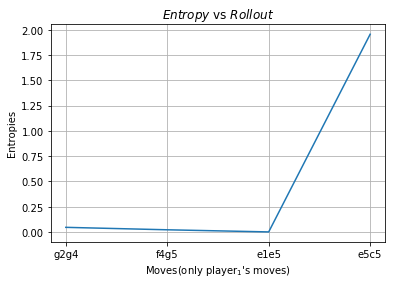

In [13]:
# This cell plots entropy vs rollout
x_axis = np.arange((len(rollout) + 1)/2, dtype = int)
x_axis_ticks = rollout[0::2]
y_axis = np.array(entropies)

plt.figure()
plt.plot(x_axis, y_axis)
plt.xticks(x_axis, x_axis_ticks)
plt.xlabel('Moves(only player$_{1}$\'s moves)')
plt.ylabel('Entropies')
plt.title('$Entropy$' + ' vs ' + '$Rollout$')
plt.grid()
plt.show()
